<a href="https://colab.research.google.com/github/minshyee/RecoSyS/blob/main/RecomSyS_using_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Matrix Factorization(MF)을 신경망으로 변환하기

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [16]:
r_cols = ['user_id','movie_id','rating','timestamp']
data_dic = '/content/drive/MyDrive/Recosys/Data/u.data'
ratings = pd.read_csv(data_dic,
                      names=r_cols,
                      sep='\t',
                      encoding='latin-1')

ratings_train, ratings_test = train_test_split(ratings, test_size=0.2, shuffle=True, random_state=2021)

In [8]:
# latent vector 
k = 200

mu = ratings_train.rating.mean() # 전체 평균

# user가 몇 명이고, 영화가 몇 개인지 세기
M = ratings.user_id.max() + 1 # +1은 bias term의 크기
N = ratings.movie_id.max() + 1

def RMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

Keras Layer에 신경망을 구성하기 위한 코드

In [9]:
# 사용자와 아이템의 입력 크기 미리 지정 -> 왜 (1,)?
user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M,k,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,k,embeddings_regularizer=l2())(item)

user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

Model Build

In [12]:
R = layers.dot([P_embedding, Q_embedding], axes=(2,2)) # 2번쨰 축(K,K)끼리 연산하겠다 

R = layers.add([R,user_bias,item_bias])

R = Flatten()(R) # 1차원으로 변경

model = Model(inputs=[user,item],outputs=R)
model.compile(loss=RMSE,
              optimizer=SGD(),
              metrics=[RMSE])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       188800      ['input_3[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       336600      ['input_4[0][0]']                
                                                                                            

In [21]:
result = model.fit(x=[ratings_train.user_id.values,
                      ratings_train.movie_id.values],
                   y=ratings_train.rating.values - mu,
                   
                   epochs=60,
                   batch_size=256,
                   validation_data = ([ratings_test.user_id.values, ratings_test.movie_id.values],
                                      ratings_test.rating.values - mu)
                   )

Epoch 1/60
313/313 [==============================] - 2s 7ms/step - loss: 1.1110 - RMSE: 1.0972 - val_loss: 1.1041 - val_RMSE: 1.0900
Epoch 2/60
313/313 [==============================] - 2s 7ms/step - loss: 1.1110 - RMSE: 1.0972 - val_loss: 1.1041 - val_RMSE: 1.0900
Epoch 3/60
313/313 [==============================] - 2s 7ms/step - loss: 1.1110 - RMSE: 1.0973 - val_loss: 1.1041 - val_RMSE: 1.0900
Epoch 4/60
313/313 [==============================] - 2s 6ms/step - loss: 1.1108 - RMSE: 1.0971 - val_loss: 1.1041 - val_RMSE: 1.0900
Epoch 5/60
313/313 [==============================] - 2s 5ms/step - loss: 1.1109 - RMSE: 1.0970 - val_loss: 1.1041 - val_RMSE: 1.0900
Epoch 6/60
313/313 [==============================] - 2s 6ms/step - loss: 1.1108 - RMSE: 1.0970 - val_loss: 1.1041 - val_RMSE: 1.0900
Epoch 7/60
313/313 [==============================] - 2s 5ms/step - loss: 1.1110 - RMSE: 1.0971 - val_loss: 1.1041 - val_RMSE: 1.0900
Epoch 8/60
313/313 [==============================] - 2s 5ms/s

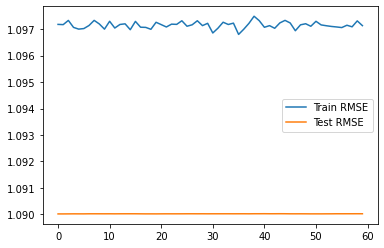

In [22]:
# PLOT
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label='Train RMSE')
plt.plot(result.history['val_RMSE'], label='Test RMSE')
plt.legend()
plt.show()

In [23]:
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]

predictions = model.predict([user_ids, movie_ids]) + mu

In [24]:
print(ratings_test[0:6])

       user_id  movie_id  rating  timestamp
23307      468        51       3  875293386
36679       92       780       3  875660494
36626      555       489       5  879975455
83753      940        69       2  885921265
52604      181      1350       1  878962120
49877      320       195       5  884749255


In [25]:
print(predictions)

[[3.555783 ]
 [3.472084 ]
 [3.5504608]
 [3.569458 ]
 [3.1841257]
 [3.5975978]]


In [26]:
import numpy as np

def RMSE_np(y_true, y_pred):
  return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [30]:
user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu

y_pred = np.ravel(y_pred,order='C') # 1차원 형태로 바꾸는 것 - order?

y_true = np.array(ratings_test.rating)

RMSE_np(y_true, y_pred)

1.0909831153232759